In [1]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#アンダーダンピングぐされた調和振動し(減衰振動子)の解析解を計算
def exact_solution(d, w0, t):
    #d：減衰係数, w0:固有振動数, t:時間
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

#PyTorchを用いて全結合ニューラルネットワークを定義
#FCNクラスはnn.Moduleクラスを継承
class FCN(nn.Module):
    #ネットワークの構造を初期化
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        #N_INPUT:入力次元数, N_OUTPUT:出力次元数, N_HIDDEN:隠れ層の次元数, N_LAYERS:隠れ層の数
        super().__init__()
        #活性化関数はTanh関数
        activation = nn.Tanh
        # 最初の全結合層と活性化関数
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        # 隠れ層の連続を定義
        #ここでは、隠れ層をN_LAYERS-1個作成
        #それぞれの隠れ層は、N_HIDDEN次元の入力を受け取り、N_HIDDEN次元の出力に変換し、その後Tanh関数を適用
        #nn.Sequentialをネストして使い、各隠れ層とその活性化関数を順に適用
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        # 最後の全結合層
        #この層は、隠れ層からの出力を、N_OUTPUT次元に変換する
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    #順伝播計算を定義
    #入力xに対して、最初にfcsを適用し、その後fchを適用し、最後にfceを適用
    #最終的な出力を返す
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


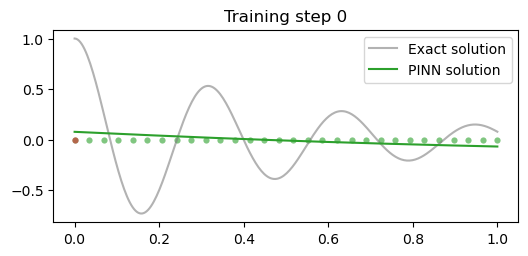

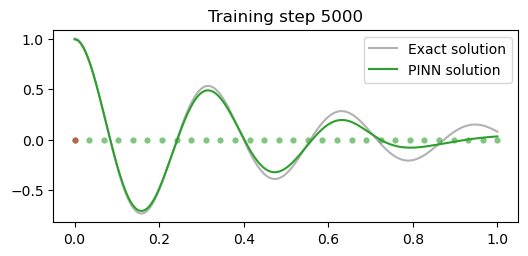

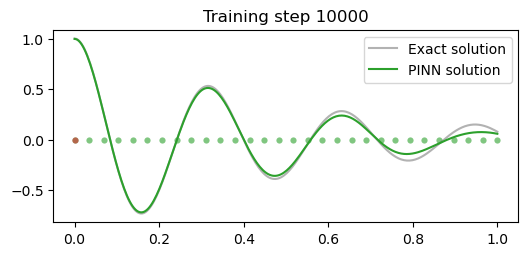

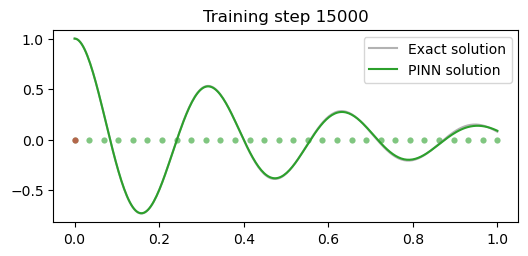

In [3]:
torch.manual_seed(123)

#ニューラルネットワークのインスタンスを作成
#これ自体はPINNではなく、PINNの一部として使われる
pinn = FCN(1,1,32,3)

# 境界条件と物理条件の訓練データを定義
# TODO # (1, 1)
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)

# define training points over the entire domain, for the physics loss
# TODO # (30, 1)
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# (30, 1)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
    #勾配を0に初期化
    #PyTorchでは、勾配（gradients）は逆伝播（backpropagation）によって計算されますが、この計算は累積されます。
    #具体的には、loss.backward()を呼び出すたびに、計算された勾配が既存の勾配に加算されます。
    #これは、多くのトレーニングループで、誤った勾配の累積が発生する可能性があるため、次のトレーニングステップを開始する前に勾配をリセットする必要あり
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1, lambda2 = 1e-1, 1e-4
    
    #境界条件の損失を計算
    # TODO
    u = pinn(t_boundary)# (1, 1)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]# (1, 1)
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    #物理条件の損失を計算
    # TODO
    u = pinn(t_physics)# (30, 1)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]# (30, 1)
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

True value of mu: 4


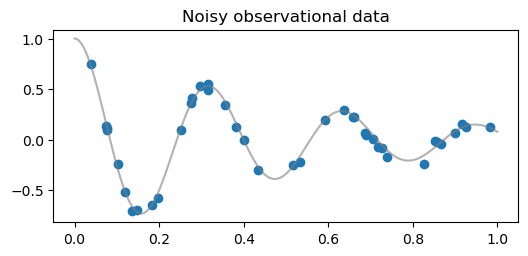

In [4]:
# first, create some noisy observational data
#アンダーダンピングされた調和振動子の理論的な解に基づいてノイズのある観測データを生成
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

plt.figure(figsize=(6,2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

In [5]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# (30, 1)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

# treat mu as a learnable parameter, add it to optimiser
# TODO
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
mus = []

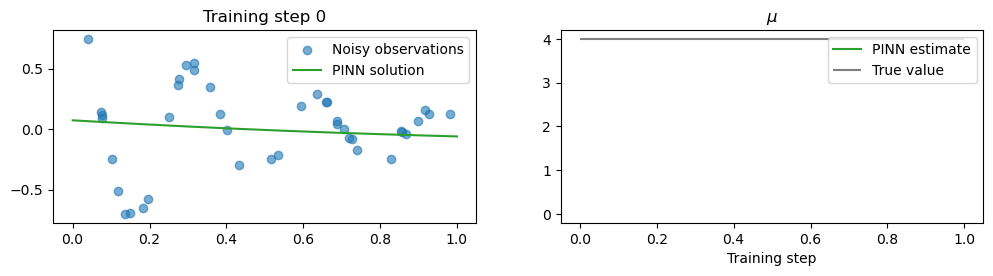

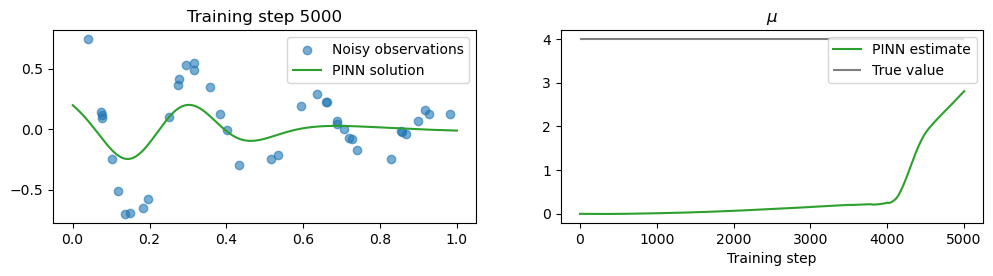

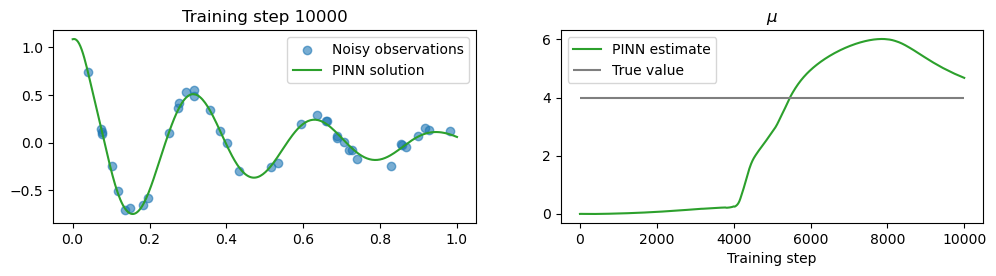

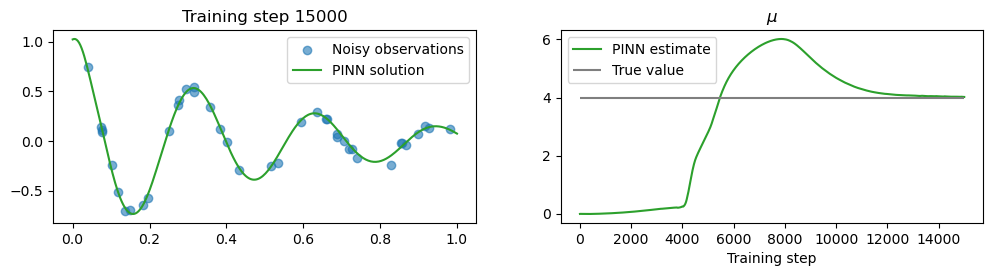

In [6]:
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1 = 1e4
    
    # compute physics loss
    u = pinn(t_physics)# (30, 1)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]# (30, 1)
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # compute data loss
    # TODO
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    mus.append(mu.item())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(12,2.5))
        
        plt.subplot(1,2,1)
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6, color="tab:blue")
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title("$\mu$")
        plt.plot(mus, label="PINN estimate", color="tab:green")
        plt.hlines(2*d, 0, len(mus), label="True value", color="tab:grey")
        plt.xlabel("Training step")
        plt.legend()
        
        plt.show()